# MCMC Model Visual Diagnostics

In this section, we will introduce a suite of diagnostic plots available in Orbit

- Density histogram
- Trace plot
- Pair plot
- Forest plot
- Posterior plot

We leveraged [arviz](https://arviz-devs.github.io/arviz/index.html) for the plotting. ArviZ is a Python package for exploratory analysis of Bayesian models, includes functions for posterior analysis, data storage, model checking, comparison and diagnostics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import orbit
from orbit.models.lgt import LGTFull
from orbit.models.dlt import DLTFull
from orbit.utils.dataset import load_iclaims
from orbit.diagnostics.plot import plot_param_diagnostics, plot_posterior_params

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
%matplotlib inline

In [2]:
print(orbit.__version__)

1.0.17


## Load data

In [3]:
raw_df = load_iclaims()
raw_df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [4]:
raw_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.386595,0.219882,-0.318452,0.117500,-0.417633,0.122654
1,2010-01-10,13.624218,0.219882,-0.194838,0.168794,-0.425480,0.110445
2,2010-01-17,13.398741,0.236143,-0.292477,0.117500,-0.465229,0.532339
3,2010-01-24,13.137549,0.203353,-0.194838,0.106918,-0.481751,0.428645
4,2010-01-31,13.196760,0.134360,-0.242466,0.074483,-0.488929,0.487404


In [5]:
df=raw_df.copy()
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

## Fit a Model

In [6]:
DATE_COL="week"
RESPONSE_COL="claims"
REGRESSOR_COL=['trend.unemploy', 'trend.filling', 'trend.job']

In [7]:
dlt = DLTFull(
    response_col=RESPONSE_COL,
    date_col=DATE_COL,
    regressor_col=REGRESSOR_COL,
    regressor_sign=["+", '+', '='], 
    seasonality=52,
    num_warmup=2000,
    num_sample=2000,
    chains=4,
)

In [8]:
dlt.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Posterior Diagnostic Viz

### trace plot

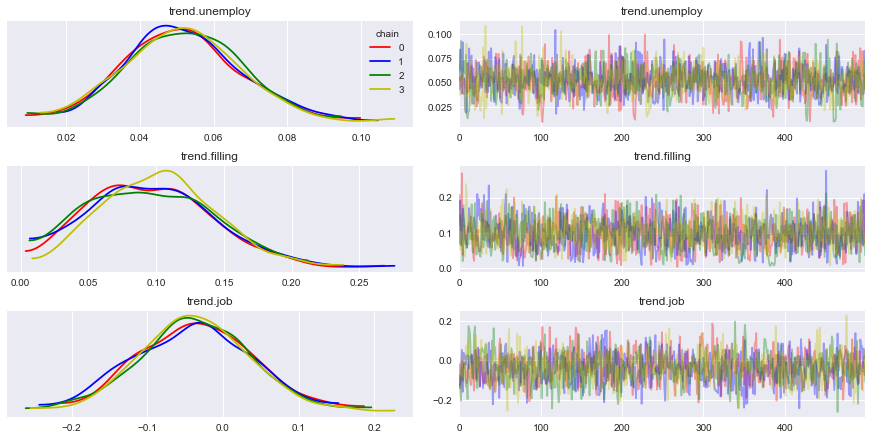

In [9]:
plot_param_diagnostics(dlt, which='trace', kind="trace", 
                       legend=True,
                       chain_prop={"color": ["r", "b","g","y"]});

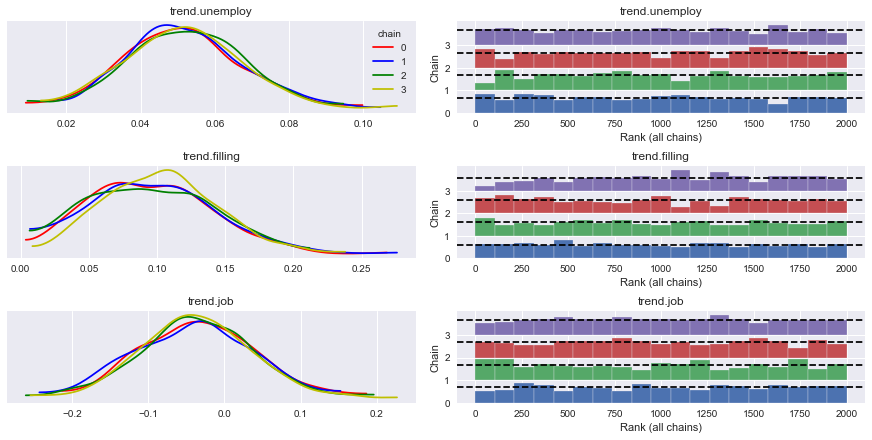

In [10]:
plot_param_diagnostics(dlt, which='trace', kind="rank_bars",
                       legend=True,
                       chain_prop={"color": ["r", "b","g","y"]});

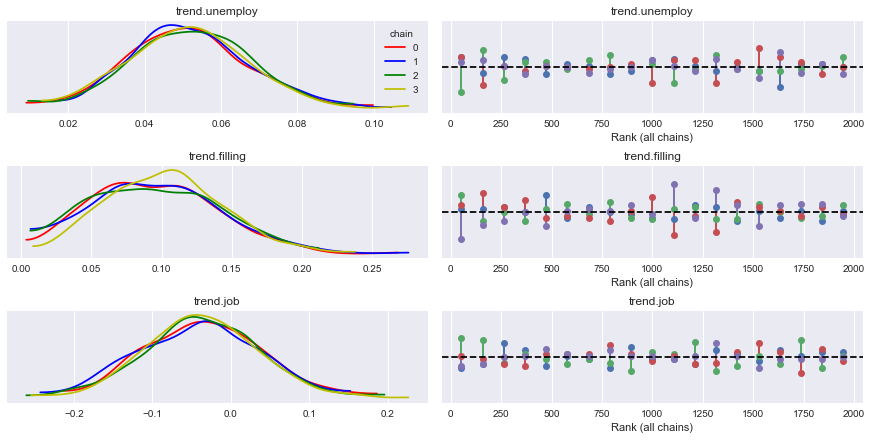

In [11]:
plot_param_diagnostics(dlt, which='trace', kind="rank_vlines",
                       legend=True,
                       chain_prop={"color": ["r", "b","g","y"]});

### density plot

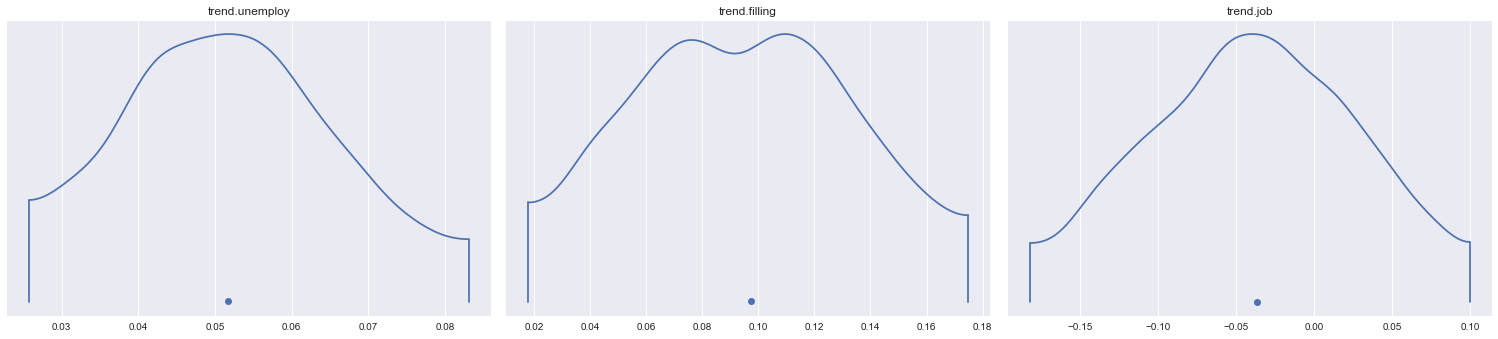

In [12]:
plot_param_diagnostics(dlt, which='density');

Meanwhile, we have our own customized plotting utility for density plot with more info added in the graph.

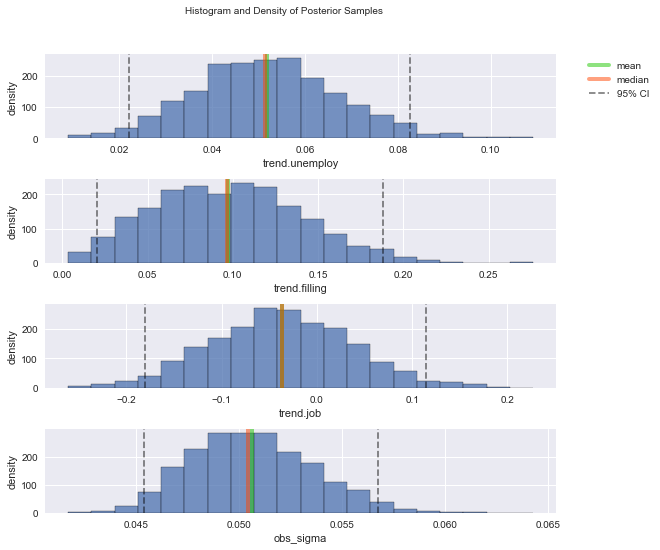

In [13]:
plot_posterior_params(dlt, kind='density');

### pair plot

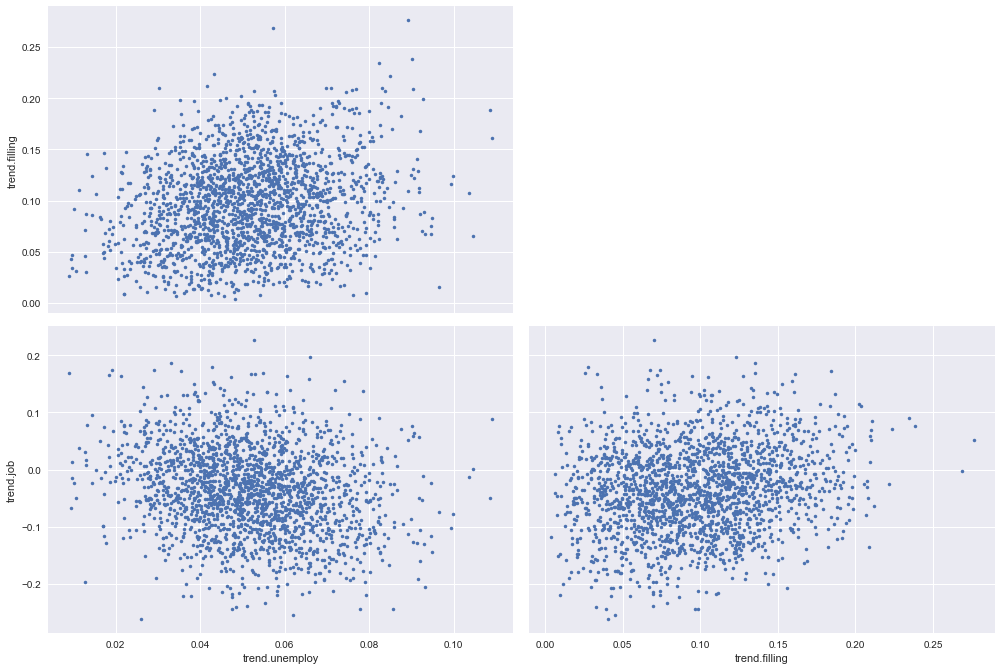

In [14]:
plot_param_diagnostics(dlt, which='pair');

### forest plot

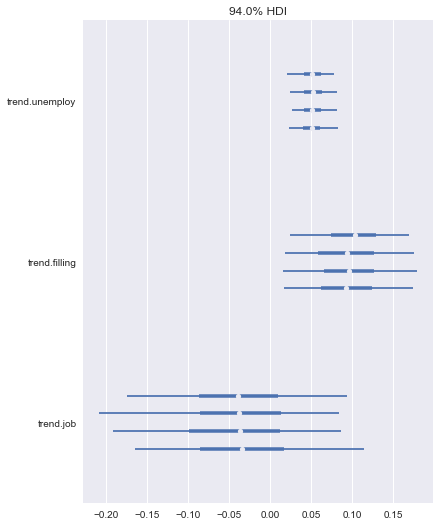

In [15]:
plot_param_diagnostics(dlt, which='forest');

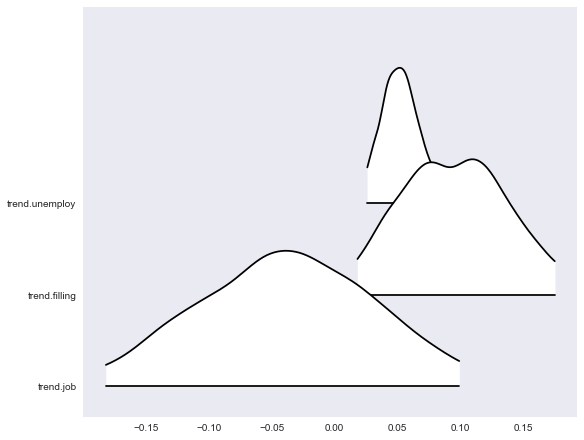

In [16]:
plot_param_diagnostics(dlt, which='forest', kind='ridgeplot', 
                       colors='white', combined=True, figsize=(8, 6));

### posterior plot

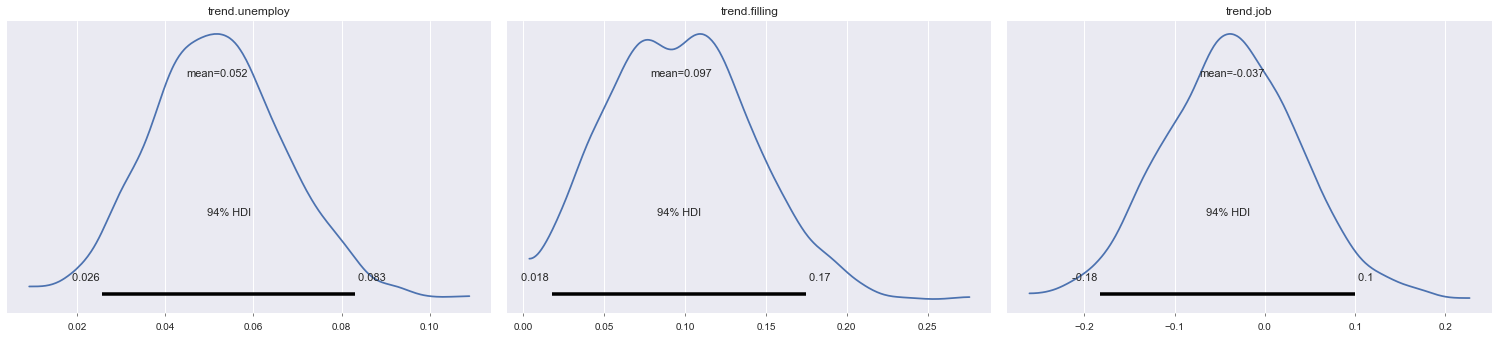

In [17]:
plot_param_diagnostics(dlt, which='posterior');